# Baseline model

Bertrand Thia (bt2513)

In this notebook, we are going to build a baseline model and explore the possible ways to improve it.

---

In [36]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Loading the data

In [2]:
train_labels = pd.read_csv('./train.csv')

In [3]:
train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

In [4]:
train_labels['label'].value_counts(normalize= True)

normal       0.310559
bacterial    0.310559
viral        0.310559
covid        0.068323
Name: label, dtype: float64

As we saw in the previous notebook, our dataset is imbalanced and the number of covid cases is very low (~6% of the data). To address this issue, we will try class weigthing and oversampling later.

# Data preprocessing

Let's split our data into a training set and a validation set, and then standardize them. 

### Splitting into training set and validation set 

In [5]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

### Loading and  standardization of the data

In [6]:
train_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization= True)

val_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization= True)

We are going to resize our images by 188 x 234 here. This is the median of the dimensions of our images divided by 3, to be more suited to neural network trainings. 

In [7]:
X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= './train/',
                                            x_col = 'filename',
                                            y_col = 'label',
                                            target_size= (188, 234), 
                                            batch_size= len(train_set), 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= './train/',
                                        x_col = 'filename',
                                        y_col = 'label',
                                        target_size= (188, 234), 
                                        batch_size= len(valid_set), 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

In [70]:
bas_model = Sequential()
bas_model.add(Conv2D(32, (3, 3), input_shape= (188, 234, 1), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu')) 
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Flatten())
bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 32, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 
bas_model.add(Dense(units= 4, activation= 'sigmoid'))

In [71]:
bas_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 186, 232, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 93, 116, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 91, 114, 32)       9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 45, 57, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 43, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 21, 27, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18144)            

In [10]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(), 
                 metrics = ['accuracy'])

* ### Training 

In [15]:
epochs= 20
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True)

In [17]:
bas_model.fit_generator(X_train, 
                        steps_per_epoch= int(len(train_set) / 32), 
                        epochs= epochs, 
                        verbose= 1, 
                        validation_data = X_val, 
                        validation_steps= int(len(valid_set) / 32),
                        callbacks= [es])

Epoch 1/20
28/28 [==============================] - 4623s 165s/step - loss: 1.0663 - accuracy: 0.4986 - val_loss: 0.7509 - val_accuracy: 0.6372
Epoch 2/20
28/28 [==============================] - 1935s 69s/step - loss: 0.7321 - accuracy: 0.6772 - val_loss: 0.6527 - val_accuracy: 0.6903
Epoch 3/20
28/28 [==============================] - 2164s 77s/step - loss: 0.5081 - accuracy: 0.7718 - val_loss: 0.7028 - val_accuracy: 0.6726
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


### Evaluating the model

In [54]:
evaluation = bas_model.evaluate(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

1/1 [==============================] - 3s 3s/step
Accuracy on the validation set: 0.690


In [31]:
pred = bas_model.predict_generator(X_val)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([3, 2, 0, 2, 3, 0, 2, 0, 2, 2])

In [28]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [34]:
y_val = valid_set['label'].map(X_val.class_indices).values

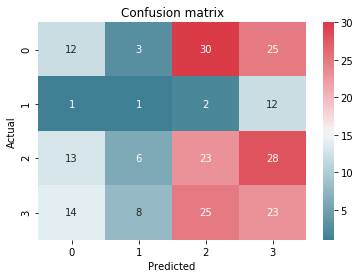

In [53]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [67]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.17      0.22        70
           1       0.06      0.06      0.06        16
           2       0.29      0.33      0.31        70
           3       0.26      0.33      0.29        70

    accuracy                           0.26       226
   macro avg       0.23      0.22      0.22       226
weighted avg       0.27      0.26      0.26       226



---

# Appendix

In [61]:
(df['y_val'] == df['y_pred']).sum() / len(df)

0.2610619469026549